In [310]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os

## MyoArmband Dataset

In [5]:
train_path = 'datasets/MyoArmbandDataset/PreTrainingDataset/'
train_candidates = 12
eval_path = 'datasets/MyoArmbandDataset/EvaluationDataset/'
eval_candidates = 15

In [411]:
def get_raw_dataset(eval_path):
    person_folders = os.listdir(eval_path)

    first_folder = os.listdir(eval_path)[0]
    keys = next(os.walk((eval_path+first_folder)))[1]

    number_of_classes = 7
    number_of_vector_per_example = 200
    size_non_overlap = 50

    raw_dataset_dict = {}
    for key in keys:
            
        raw_dataset = {
            'examples': [],
            'labels': [],
        }
        list_dataset = []
        list_labels = []
        for person_dir in person_folders:
            examples = []
            labels = []
            data_path = eval_path + person_dir + '/' + key
            for data_file in os.listdir(data_path):
                if (data_file.endswith(".dat")):
                    data_read_from_file = np.fromfile((data_path+'/'+data_file), dtype=np.int16)
                    data_read_from_file = np.array(data_read_from_file, dtype=np.float32)

                    dataset_example_formatted = []
                    example = []
                    emg_vector = []
                    for value in data_read_from_file:
                        emg_vector.append(value)
                        if (len(emg_vector) >= 8):
                            if (example == []):
                                example = emg_vector
                            else:
                                example = np.row_stack((example, emg_vector))
                            emg_vector = []
                            if (len(example) >= number_of_vector_per_example):
                                example = example.transpose()
                                dataset_example_formatted.append(example)
                                example = example.transpose()
                                example = example[size_non_overlap:]
                    dataset_example_formatted = np.array(dataset_example_formatted)
                    examples.append(dataset_example_formatted)
                    data_file_index = int(data_file.split('classe_')[1][:-4])
                    label = data_file_index % number_of_classes + np.zeros(dataset_example_formatted.shape[0])
                    labels.append(label)

            raw_dataset['examples'].append(np.concatenate(examples))
            raw_dataset['labels'].append(np.concatenate(labels))

        raw_dataset_dict[key] = raw_dataset

    return raw_dataset_dict

In [412]:
eval_raw_dataset_dict = get_raw_dataset(eval_path)

/var/folders/k8/_qw1v4gj2cv9cqh75_yrt3pc0000gn/T/ipykernel_31040/548029492.py:35: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (example == []):


In [60]:
train_raw_dataset_dict = get_raw_dataset(train_path)

/var/folders/k8/_qw1v4gj2cv9cqh75_yrt3pc0000gn/T/ipykernel_31040/3666496798.py:35: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (example == []):


In [414]:
len(train_raw_dataset_dict['training0']['examples'])

22

In [415]:
len(eval_raw_dataset_dict['training0']['examples'])

18

In [417]:
eval_raw_dataset_dict['training0']['examples'][0].shape

(454, 8, 200)

In [83]:
# all people
train_x = np.concatenate(eval_raw_dataset_dict['training0']['examples'])
train_y = np.concatenate(eval_raw_dataset_dict['training0']['labels'])
test_x = np.concatenate(eval_raw_dataset_dict['Test0']['examples'])
test_y = np.concatenate(eval_raw_dataset_dict['Test0']['labels'])

In [66]:
# all people eval + training
train_x = np.concatenate(eval_raw_dataset_dict['training0']['examples']+train_raw_dataset_dict['training0']['examples'])
train_y = np.concatenate(eval_raw_dataset_dict['training0']['labels']+train_raw_dataset_dict['training0']['labels'])
test_x = np.concatenate(eval_raw_dataset_dict['Test0']['examples'])
test_y = np.concatenate(eval_raw_dataset_dict['Test0']['labels'])

## Nina Pro DB5

In [311]:
from scipy.io import loadmat

In [313]:
emg_min = -128.
emg_max = 127.

sampling_rate = 200 # Hz
window_length = sampling_rate # 1 second
overlap = 50
stride = window_length - overlap

In [359]:
def create_window_dataset(X, y):
    features_dataset = {key: [] for key in np.unique(y)}
    last_class_idx = None
    consequetive_features = []

    for class_idx, feature in zip(y, X):
        if class_idx != last_class_idx:
            if consequetive_features:
                features_dataset[class_idx].append(np.array(consequetive_features))
            consequetive_features = [feature]
            last_class_idx = class_idx
        else:
            consequetive_features.append(feature)

    if consequetive_features:
        features_dataset[class_idx].append(np.array(consequetive_features))

    windows = []
    labels = []
    for class_idx, feature_list in features_dataset.items():
        for consequetive_features in feature_list:
            num_windows = (consequetive_features.shape[0] - window_length) // stride + 1
            for i in range(num_windows):
                start = i * stride
                end = start + window_length
                window = consequetive_features[start:end, :]
                windows.append(window)
                labels.append(class_idx)

    return np.array(windows, dtype=np.float32), np.array(labels, dtype=int)

In [383]:
windows = None
lables = None

ninapro_base_dir = 'datasets/NinaProDB5/'
ninapro_person_dirs = next(os.walk(ninapro_base_dir))[1]
for nina_person_dir in ninapro_person_dirs:
    subject_id = nina_person_dir[-1]
    files = os.listdir(ninapro_base_dir + nina_person_dir)
    for file in files:
        if file.endswith('E1_A1.mat'):
            print(file)
            filepath = ninapro_base_dir + nina_person_dir + '/' + file

            ninapro_s1 = loadmat(filepath)

            ninapro_s_x_raw = ninapro_s1['emg'][:, :8]
            ninapro_s_x = np.interp(ninapro_s_x_raw, (emg_min, emg_max), (-1, +1))
            ninapro_s_y = ninapro_s1['restimulus'].squeeze()

            subject_windows, subject_labels = create_window_dataset(X = ninapro_s_x, y = ninapro_s_y)

            if windows is None:
                windows = subject_windows
                labels = subject_labels
            else:
                windows = np.concatenate((windows, subject_windows))
                labels = np.concatenate((labels, subject_labels))

windows = windows.swapaxes(1,2)

S5_E1_A1.mat
S2_E1_A1.mat
S3_E1_A1.mat
S4_E1_A1.mat
S10_E1_A1.mat
S8_E1_A1.mat
S1_E1_A1.mat
S6_E1_A1.mat
S7_E1_A1.mat
S9_E1_A1.mat


In [384]:
windows.shape, labels.shape

((8515, 8, 200), (8515,))

In [387]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [388]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(windows, labels)

In [389]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomEMGDataset(Dataset):
    def __init__(self, x_samples, y_samples):
        self.x_samples = x_samples
        self.y_samples = y_samples

    def __len__(self):
        return len(self.x_samples)
    
    def __getitem__(self, idx):
        x_tensor = torch.tensor(self.x_samples[idx,:,:])
        y_tensor = torch.tensor(self.y_samples[idx]).type(torch.LongTensor)
        return x_tensor, y_tensor

In [390]:
train_dataset = CustomEMGDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomEMGDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [391]:
x, y = next(iter(test_dataloader))

<AxesSubplot:>

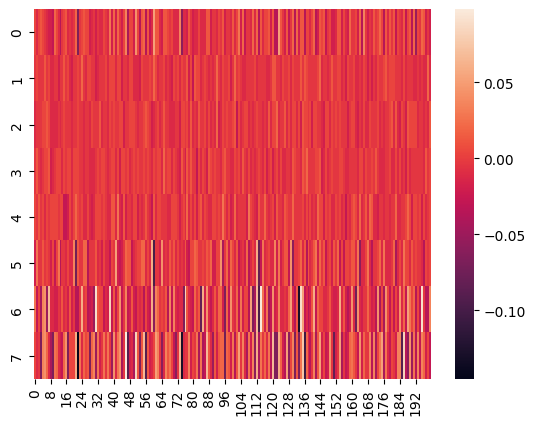

In [392]:
sns.heatmap(x[0,:,:])

In [393]:
import torch
import torch.nn as nn

In [394]:
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out

In [400]:
train_features, train_labels = next(iter(train_dataloader))

In [354]:
device = 'mps'

In [404]:
model = FFNN(200*8, 128, 13).to(device)

In [406]:
model(train_features.to(device)).shape

torch.Size([32, 13])

In [408]:
import torch
from vit_pytorch import ViT

model = ViT(
    image_size = 200,
    patch_size = 4,
    num_classes = 13,
    dim = 64,
    depth = 2,
    heads = 4,
    mlp_dim = 128,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels=1,
).to(device) 

img = torch.randn(10, 1, 8, 200).to(device)

preds = model(img)

In [409]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [410]:
history = {
    'accs': [],
    'losses': [],
}

for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        model.train()
        # get the inputs; data is a list of [inputs, labels]
        train_inputs, train_labels = data
        train_inputs = train_inputs.to(device)
        train_labels = train_labels.to(device)

        if model.__class__.__name__ == 'ViT':
            train_inputs.unsqueeze_(axis=1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(train_inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        history['losses'].append(loss.item())
        if i % 1000 == 999:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.8f}')
            running_loss = 0.0

    accs = []
    for data in test_dataloader:
        test_inputs, test_labels = data
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        if model.__class__.__name__ == 'ViT':
            test_inputs.unsqueeze_(axis=1)
        model.eval()
        with torch.no_grad():
            outputs = model(test_inputs)
            predicted_labels = outputs.cpu().max(dim=1).indices

        test_labels = test_labels.cpu()
        acc = accuracy_score(test_labels, predicted_labels)
        accs.append(acc)

    history['accs'].append( np.mean(accs))
    print('test accuracy', np.mean(accs))

print('Finished Training')

test accuracy 0.38504170324846354
test accuracy 0.39845807726075505
test accuracy 0.40317712906057945
test accuracy 0.41618195785776996
test accuracy 0.4038904741000878
test accuracy 0.39928116769095695
test accuracy 0.37928007023705
test accuracy 0.39928116769095695
test accuracy 0.41083187006145744
test accuracy 0.39810140474100086
test accuracy 0.40068042142230026
test accuracy 0.4021894205443371
test accuracy 0.40084503950834066
test accuracy 0.4062225636523266
test accuracy 0.41758121158911327
test accuracy 0.40196992976295
test accuracy 0.4115177787532923
test accuracy 0.41700504828797186
test accuracy 0.405975636523266
test accuracy 0.4145906496927129
test accuracy 0.40690847234416155
test accuracy 0.40188762071992973
test accuracy 0.4098990342405619
test accuracy 0.39933604038630377
test accuracy 0.41058494293239683
test accuracy 0.37969161545215097
test accuracy 0.3935744073748903
test accuracy 0.39332748024582964
test accuracy 0.39741549604916593
test accuracy 0.3926415715539

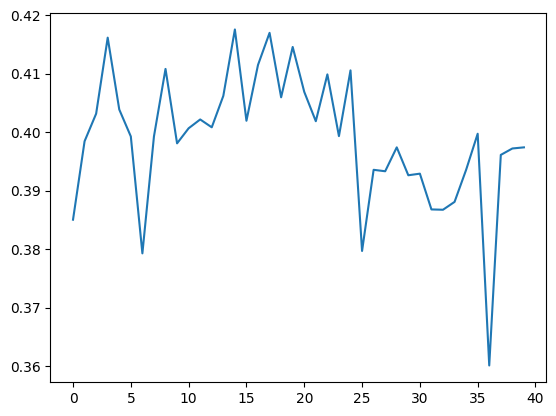

In [413]:
plt.plot(history['accs'])

In [ ]:
plt.plot(history['losses'])

In [92]:
import time

In [91]:
single_test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [94]:
dts = []
for data in single_test_dataloader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    if model.__class__.__name__ == 'ViT':
        inputs.unsqueeze_(axis=1)
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = outputs.cpu().max(dim=1).indices

    dt = time.time() - start_time
    dts.append(dt)
    # print('dt', dt)

In [101]:
torch.save(model, 'pretained_vit.pt')

In [102]:
model_state_dict = model.state_dict()
torch.save(model_state_dict, 'pretained_vit_state_dict.pt')

In [96]:
dts = np.array(dts)
dts[0]

0.0048601627349853516

In [105]:
1 / dts[1:].mean(), 'Hz'

(333.90465095197, 'Hz')

# Transfer learning

**TODO**
Try if this improves performance

In [23]:
import copy
from pprint import pprint

import torch

# Models
# Encoder
G = torch.nn.Linear(1000, 100)
# CLassification head
C = torch.nn.Linear(100, 10)

D = torch.nn.Sequential(torch.nn.Linear(100, 1), torch.nn.Flatten(start_dim=0))
G_opt = torch.optim.Adam(G.parameters())
C_opt = torch.optim.Adam(C.parameters())
D_opt = torch.optim.Adam(D.parameters())

dataset_size = 10000
# 1 batch of data
example_data = {
    "src_imgs": torch.randn(32, 1000),
    "target_imgs": torch.randn(32, 1000),
    "src_labels": torch.randint(0, 10, size=(32,)),
    "src_domain": torch.zeros(32),
    "target_domain": torch.zeros(32),
    "src_sample_idx": torch.randint(0, dataset_size, size=(32,)),
    "target_sample_idx": torch.randint(0, dataset_size, size=(32,)),
}


def get_data(keys):
    return {k: example_data[k] for k in keys}

In [24]:
from pytorch_adapt.hooks import MCDHook
from pytorch_adapt.layers import MultipleModels, SlicedWasserstein
from pytorch_adapt.utils import common_functions as c_f

In [50]:
# MCD needs 2 classifiers
C_ = MultipleModels(C, c_f.reinit(copy.deepcopy(C)))
C_opt_ = torch.optim.Adam(C_.parameters())
loss_fn = SlicedWasserstein(m=128)

hook = MCDHook(g_opts=[G_opt], c_opts=[C_opt_], discrepancy_loss_fn=loss_fn)

models = {"G": G, "C": C_}
data = get_data(["src_imgs", "target_imgs", "src_labels"])
_, losses = hook({**models, **data})
pprint(losses)

{'x_loss': {'src_c_loss0': 0.006591843441128731,
            'src_c_loss1': 2.502946615219116,
            'total': 1.254769206047058},
 'y_loss': {'discrepancy_loss': -0.4307219982147217,
            'src_c_loss0': 0.005981766618788242,
            'src_c_loss1': 2.2412302494049072,
            'total': 0.6054966449737549},
 'z_loss': {'discrepancy_loss': 0.2203170657157898,
            'total': 0.2203170657157898}}
